In [2]:
%pip install standard-precip

Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
from scipy.stats import gamma, norm

from standard_precip.spi import SPI
from standard_precip.utils import plot_index

In [86]:
input_data = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\modelled_data_snowdrought\onset_to_peak_data.csv'
output_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\SPI\\'


In [75]:
rainfall_data = pd.read_csv(input_data)
rainfall_data.set_index('time', inplace=True)

display(rainfall_data.head())

,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change,cumulative_P
time,,,,,,,,,
1981-02-11,1,-116.13797,51.33459,152.250,0.000000,2000_2500m,1980,0.570312,0.000000
1980-11-07,1,-116.13797,51.33459,27.000,2.128011,2000_2500m,1980,0.000000,2.128011
1980-12-21,1,-116.13797,51.33459,110.625,3.271602,2000_2500m,1980,0.000000,5.399613
1980-10-25,1,-116.13797,51.33459,12.625,0.000000,2000_2500m,1980,27.875000,5.399613
1980-11-13,1,-116.13797,51.33459,40.500,0.007695,2000_2500m,1980,13.000000,5.407308


In [76]:
# remove lat, lon and SWE columns if they exist
rainfall_data = rainfall_data.drop(columns=['lat', 'lon', 'SWE','daily_SWE_change','cumulative_P'], errors='ignore')

# Rename columns if needed (update based on your actual header)
rainfall_data.columns = [col.strip() for col in rainfall_data.columns]
# The index may not be datetime yet, so convert it first
rainfall_data.index = pd.to_datetime(rainfall_data.index)

# The index is now datetime, so we can just assign it to a new column if needed
rainfall_data['Date'] = rainfall_data.index

# Filter for Oct–May only
rainfall_data = rainfall_data[rainfall_data.index.month.isin([10, 11, 12, 1, 2, 3, 4, 5])]

display(rainfall_data.head())

,Grid_id,Precipitation,Elevation_Category,Season_year,Date
time,,,,,
1981-02-11,1,0.000000,2000_2500m,1980,1981-02-11
1980-11-07,1,2.128011,2000_2500m,1980,1980-11-07
1980-12-21,1,3.271602,2000_2500m,1980,1980-12-21
1980-10-25,1,0.000000,2000_2500m,1980,1980-10-25
1980-11-13,1,0.007695,2000_2500m,1980,1980-11-13


In [77]:
# Calculate monthly precipitation for each season year and grid point
monthly_precip = (
    rainfall_data
    .groupby(['Grid_id', 'Season_year', pd.Grouper(key='Date', freq='M')])['Precipitation']
    .sum()
    .reset_index()
)

# Add elevation category for each Grid_id
# Get unique mapping from Grid_id to Elevation_Category
elevation_map = rainfall_data[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

display(monthly_precip.head())

,Grid_id,Season_year,Date,Precipitation,Elevation_Category
0,1,1980,1980-10-31,9.161071,2000_2500m
1,1,1980,1980-11-30,50.295086,2000_2500m
2,1,1980,1980-12-31,108.955549,2000_2500m
3,1,1980,1981-01-31,13.916898,2000_2500m
4,1,1980,1981-02-28,38.431036,2000_2500m


In [81]:
# Calculate monthly average precipitation for each Elevation_Category, Season_year, and month
monthly_avg = (
    monthly_precip
    .groupby(['Elevation_Category', 'Season_year', monthly_precip['Date']])['Precipitation']
    .mean()
    .unstack(level=0)  # Elevation_Category as columns
)

# Rename columns to match the format "2000-2500m_P"
monthly_avg.columns = [f"{col}_P" for col in monthly_avg.columns]

display(monthly_avg.head(10))

1000_1500m_P  1500_2000m_P  2000_2500m_P  500_1000m_P
Season_year Date                                                             
1980        1980-10-31     11.278646     23.107287     16.283314     6.029624
            1980-11-30     23.173287     32.786186     52.304052    12.598151
            1980-12-31     15.068457     33.435977     94.355993    17.063118
            1981-01-31      9.967167     10.810990     11.316449    11.567617
            1981-02-28      8.874055     13.449608     29.459216     2.885608
            1981-03-31      9.372507     10.285527     14.930461          NaN
            1981-04-30     11.146534     15.148091     28.866890          NaN
            1981-05-31     94.505921     93.067019     60.196373          NaN
1981        1981-10-31     15.946284     13.428639     33.749206     8.283148
            1981-11-30      4.466762      6.709451     12.219782     7.166000

In [88]:
# Save the combined data to a CSV file
monthly_avg.to_csv(output_path + 'monthly_precipitation.csv')


In [84]:
# Create the SPI object
spi = SPI()

# Calculate SPI using the created spi object
df_spi = spi.calculate(
    monthly_avg, 
    'Date', 
    '1000_1500m_P', 
    freq="M", 
    scale=7, 
    fit_type="lmom", 
    dist_type="gam"
)

KeyError: Index(['Date'], dtype='object')

In [72]:
display(df_spi.head())

,Date,Precipitation_scale_6,Precipitation_scale_6_calculated_index
0,1980-10-31,NaN,NaN
1,1980-11-30,NaN,NaN
2,1980-12-31,NaN,NaN
3,1981-01-31,NaN,NaN
4,1981-02-28,NaN,NaN


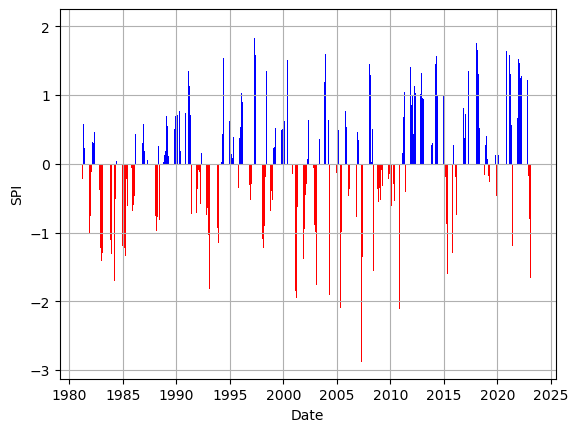

In [71]:
fig = plot_index(df_spi, 'Date', 'Precipitation_scale_6_calculated_index')